In [15]:
import os, sys, time, pickle

from tqdm.notebook import tqdm
import pandas as pd
import json
import numpy as np
from collections import defaultdict
from scipy import stats
from datasets import load_from_disk
from transformers import ViTForImageClassification
from utils.helper import get_device
from utils.vit_util import transforms, transforms_c100, identfy_tgt_misclf
from utils.constant import ViTExperiment
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
import torch
device = get_device()

Device: cuda


# やりたいこと - レイヤごとの VScore の可視化

In [56]:
ds_name = "tiny-imagenet"
# ds_name = "c100"
k = 0
# pretrained modelのロード
pretrained_dir = getattr(ViTExperiment, ds_name.replace("-", "_")).OUTPUT_DIR.format(k=k)
model = ViTForImageClassification.from_pretrained(pretrained_dir).to(device)
model.eval()
# 対象の設定
start_li = 0
target_li = -1
end_li = model.vit.config.num_hidden_layers

# datasetごとに違う変数のセット
if ds_name == "c10" or ds_name == "tiny-imagenet":
    tf_func = transforms
    label_col = "label"
    num_labels = 10
elif ds_name == "c100":
    tf_func = transforms_c100
    label_col = "fine_label"
    num_labels = 100
else:
    NotImplementedError
    
# 対象の誤分類種類
misclf_types_ranks = [("src_tgt", None), ("tgt", "fp"), ("tgt", "fn")]
tgt_ranks = [1, 2, 3]

# 誤分類データのpickle
misclf_info_dir = os.path.join(pretrained_dir, "misclf_info")

Processing misclassification type: src_tgt, fpfn: None, target rank: 1
misclf_pair=(66, 0), tgt_label=None
vscore_mis shape: (12, 3072)
vscore_cor shape: (12, 3072)


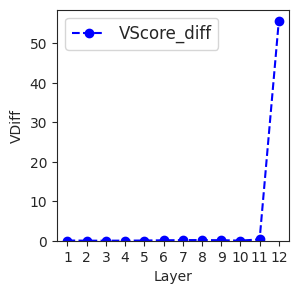

Processing misclassification type: src_tgt, fpfn: None, target rank: 2
misclf_pair=(95, 86), tgt_label=None
vscore_mis shape: (12, 3072)
vscore_cor shape: (12, 3072)


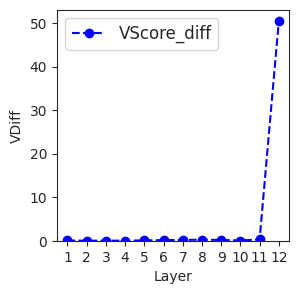

Processing misclassification type: src_tgt, fpfn: None, target rank: 3
misclf_pair=(117, 157), tgt_label=None
vscore_mis shape: (12, 3072)
vscore_cor shape: (12, 3072)


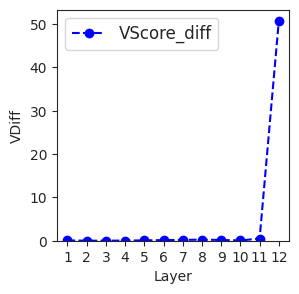

Processing misclassification type: tgt, fpfn: fp, target rank: 1
misclf_pair=None, tgt_label=9
vscore_mis shape: (12, 3072)
vscore_cor shape: (12, 3072)


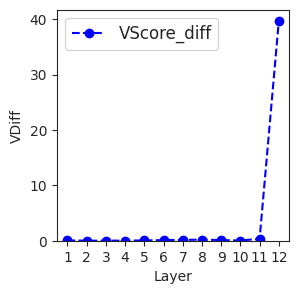

Processing misclassification type: tgt, fpfn: fp, target rank: 2
misclf_pair=None, tgt_label=118
vscore_mis shape: (12, 3072)
vscore_cor shape: (12, 3072)


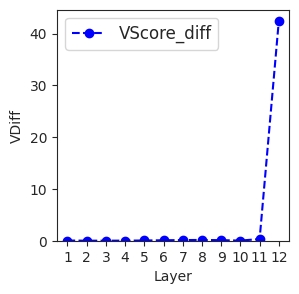

Processing misclassification type: tgt, fpfn: fp, target rank: 3
misclf_pair=None, tgt_label=176
vscore_mis shape: (12, 3072)
vscore_cor shape: (12, 3072)


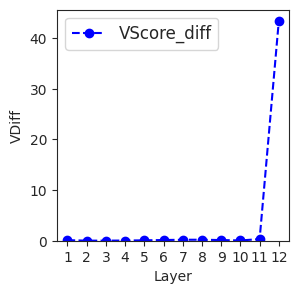

Processing misclassification type: tgt, fpfn: fn, target rank: 1
misclf_pair=None, tgt_label=0
vscore_mis shape: (12, 3072)
vscore_cor shape: (12, 3072)


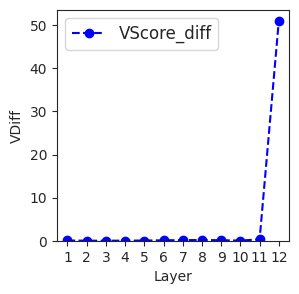

Processing misclassification type: tgt, fpfn: fn, target rank: 2
misclf_pair=None, tgt_label=9
vscore_mis shape: (12, 3072)
vscore_cor shape: (12, 3072)


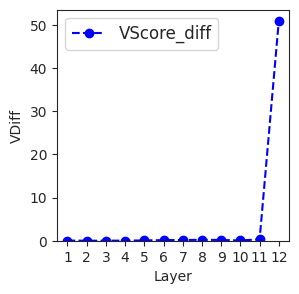

Processing misclassification type: tgt, fpfn: fn, target rank: 3
misclf_pair=None, tgt_label=25
vscore_mis shape: (12, 3072)
vscore_cor shape: (12, 3072)


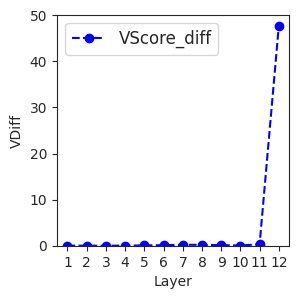

In [67]:
for misclf_type, fpfn in misclf_types_ranks:
    for tgt_rank in tgt_ranks:
        print(f"Processing misclassification type: {misclf_type}, fpfn: {fpfn}, target rank: {tgt_rank}")
        misclf_dir = os.path.join(pretrained_dir, f"misclf_top{tgt_rank}")
        vscore_dir = os.path.join(misclf_dir, f"vscores")
        # 対象の誤分類ラベルを特定
        misclf_pair, tgt_label, tgt_mis_indices = identfy_tgt_misclf(misclf_info_dir, misclf_type=misclf_type, tgt_rank=tgt_rank, fpfn=fpfn)
        # 誤分類のディレクトリ
        if not os.path.exists(misclf_dir):
            raise FileNotFoundError(f"Directory {misclf_dir} does not exist.")
        print(f"misclf_pair={misclf_pair}, tgt_label={tgt_label}")
        # 誤分類ラベルがわかったらvscore_file_nameがわかる
        if misclf_type == "src_tgt":
            vscore_file_name = f"vscore_abs_l1tol12_{misclf_pair[0]}to{misclf_pair[1]}_ori_repair_mis.npy"
        elif misclf_type == "tgt":
            vscore_file_name = f"vscore_abs_l1tol12_{tgt_label}_ori_repair_{fpfn}_mis.npy"
        vscore_file_path = os.path.join(vscore_dir, vscore_file_name)
        if not os.path.exists(vscore_file_path):
            raise FileNotFoundError(f"Vscore file {vscore_file_path} does not exist.")
        # vscore (mis) のロード
        vscore_mis = np.load(vscore_file_path, allow_pickle=True)
        print(f"vscore_mis shape: {vscore_mis.shape}")
        # vscore (cor) のロード
        vscore_file_path = os.path.join(vscore_dir, "vscore_abs_l1tol12_all_label_ori_repair_cor.npy")
        vscore_cor = np.load(vscore_file_path, allow_pickle=True)
        print(f"vscore_cor shape: {vscore_cor.shape}")
        
        
        # 描画フェーズ
        vdiff = np.abs(vscore_cor.T - vscore_mis.T)
        # vdiff_norms = np.linalg.norm(vdiff, axis=0)
        vdiff_means = vdiff.mean(axis=0) 
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.plot(vdiff_means, color="b", marker="o", linestyle="--", label="VScore_diff")
        ax.set_xlabel("Layer")
        ax.set_ylabel("VDiff")
        # y軸を0から始める
        ax.set_ylim(bottom=0)
        # グラフに凡例を追加
        ax.legend(loc='upper left', fontsize='large')
        plt.xticks(np.arange(0, end_li-start_li, 1), np.arange(start_li+1, end_li+1, 1))
        plt.show()